<h1>**IBM Model 1**</h1>

1. a) Implement EM training (Brown et al., 1993) for IBM model 1; <br />
    b) Implement variational inference for Bayesian IBM model 1; <br />
    c) All of the tasks below should be performed for both models.<br />
2. Plot the evolution of training log likelihood (or ELBO) as a function of the iteration.
3. Plot the evolution of alignment error rate (AER) on validation data as a function of the iteration;
4. Experiment with two criteria for model selection (i.e. deciding on number of training iterations): 
    1) convergence in terms of training log likelihood; 
    2) best AER on validation data;
5. For the selected models, obtain Viterbi alignments for every sentence pair in a test
corpus and compute AER using a gold-standard provided by the assistant;

In [10]:
import aer
from collections import defaultdict, Counter
import json
from math import log2
import numpy as np
from random import randint
import random
import progressbar
import pickle
import matplotlib.pyplot as plt
from scipy.special import digamma, gammaln 
import os
%matplotlib inline

In [23]:
def read_corpus(file_name, source_language):
    """
    Reads the corpus and saves each sentence in a list.
    """
    
    corpus = []
    
    with open(file_name, "r", encoding='utf8') as f:
        for line in f:
            line = line.replace("\n", "")
            sentence = line.split()
            
            if source_language:
                sentence.insert(0, "null")
            corpus.append(sentence)
    return corpus


def reduce_corpus(corpus):
    """
    Reduces the vocabulary of the corpus by replacing each word that only
    occurs once in the vocabulary by -LOW- in the corpus.
    """
    
    flat_corpus = [word for sentence in corpus for word in sentence]
    word_counts = Counter(flat_corpus)
    small_corpus = []
    
    for sentence in corpus:
        small_sentence = []
        
        for word in sentence:
            if word_counts[word] != 1:
                small_sentence.append(word)
            else:
                small_sentence.append("-LOW-")
        small_corpus.append(small_sentence)
    return small_corpus

    
train_source = read_corpus("training/hansards.36.2.e", True)
train_source = reduce_corpus(train_source)
print("Read training source corpus")
train_target = read_corpus("training/hansards.36.2.f", False)
train_target = reduce_corpus(train_target)
print("Read training target corpus")
val_source = read_corpus("validation/dev.e", True)
val_target = read_corpus("validation/dev.f", False)
print("Read validation corpora")
test_source = read_corpus("testing/test/test.e", True)
test_target = read_corpus("testing/test/test.f", False)
print("Read test corpora")

Read training source corpus
Read training target corpus
Read validation corpora
Read test corpora


In [24]:
def initialise_parameters(source_corpus, target_corpus, method):
    """
    Initialises the conditional probability of generating a source 
    word from a target word for all possible pairs of words in the source 
    and target sentences to 5 and then normalises the parameters such that 
    the initialisation is uniform.
    """
    
    if method == "uniform":
        vocabulary = set([word for sentence in source_corpus for word in sentence])
        theta0 = 1/len(vocabulary)
        return defaultdict(lambda: defaultdict(lambda: theta0))
    elif method == "random":
        theta0 = np.random.uniform(0.001, 1)
        return defaultdict(lambda: defaultdict(lambda: theta0))
    elif method == "ibm1":
        file_path = get_best_aer()
        parameters = load_parameters(file_path)
        return parameters      


def expectation_maximisation(train_source, train_target, val_source,
                             val_target, parameters, num_iterations, 
                             min_perplexity_change, model):
    """
    Do the EM algorithm until perplexity decreases very little or until 
    the number of iterations is reached.
    """
    
    old_perplexity = -100000
    perplexities = []
    aers = []
    best_aer = 1
    best_parameters = parameters
    
    for k in range(0, num_iterations):
        print("Iteration #" + str(k), "out of", num_iterations - 1)
        counts_single = defaultdict(lambda: 1.0)
        counts_pairs = defaultdict(lambda: defaultdict(float))
        counts_single, counts_pairs = e_step(train_source, train_target,
                                             parameters, counts_single, 
                                             counts_pairs)
        parameters = m_step(parameters, counts_single, counts_pairs)
        perplexity = compute_perplexity(parameters, train_source, train_target)
        alignments = get_best_alignment(val_source, val_target, parameters)
        val_aer = compute_aer(alignments, "validation/dev.wa.nonullalign")
        aers.append(val_aer)
        perplexities.append(perplexity)
        
        # Convergence in terms of training log likelihood
        if model == "likelihood":
            if abs(perplexity - old_perplexity) < min_perplexity_change:
                return perplexities, aers, best_parameters
            else:
                old_perplexity = perplexity
                best_parameters = parameters
        # Convergence in terms of best AER on validation data
        elif model == "aer":
            if val_aer < best_aer:
                best_aer = val_aer
                best_parameters = parameters
            else:
                return perplexities, aers, best_parameters
    return perplexities, aers, parameters
    
    
def e_step(source_corpus, target_corpus, parameters, counts_single, 
           counts_pairs):
    """
    Do the E-step by computing the expected counts.
    """
    
    print("Doing E-step...")
    
    with progressbar.ProgressBar(max_value=len(target_corpus)) as bar:
        for n in range(len(target_corpus)):
            target_sentence = target_corpus[n]
            source_sentence = source_corpus[n]

            for i in range(len(target_sentence)):
                normalisation_term = 0
                target_word = target_sentence[i]

                for j in range(len(source_sentence)):
                    source_word = source_sentence[j]
                    normalisation_term += parameters[source_word][target_word]
                for j in range(len(source_sentence)):
                    source_word = source_sentence[j]
                    expected_count = parameters[source_word][target_word]/normalisation_term
                    counts_pairs[source_word][target_word] += expected_count
                    counts_single[source_word] += expected_count
            bar.update(n)
    return counts_single, counts_pairs


def m_step(parameters, counts_single, counts_pairs):
    """
    Do the M-step by normalising the parameters.
    """
    
    print("Doing M-step...")
    
    with progressbar.ProgressBar(max_value=len(counts_pairs)) as bar:
        i = 0
        for source_word, target_words in counts_pairs.items():
            for target_word, expected_count in target_words.items():
                parameters[source_word][target_word] = expected_count/counts_single[source_word]
            i += 1
            bar.update(i)
    return parameters


def compute_perplexity(parameters, source_corpus, target_corpus):
    """
    Computes the perplexity of the corpus.
    """
    
    perplexity = 0
    
    for n in range(len(source_corpus)):
        source_sentence = source_corpus[n]
        target_sentence = target_corpus[n]
        log_sentence = 0
        
        for target_word in target_sentence: 
            log_sum = []
            
            for source_word in source_sentence: 
                log_sum.append(parameters[source_word][target_word])
            log_sentence += np.log(np.sum(log_sum))
        perplexity += log_sentence
    print(perplexity)
    return perplexity
   

def get_best_alignment(source_corpus, target_corpus, parameters):
    """
    Gets the best alignment for each sentence and saves the alignment
    in a list of lists that holds tuples for each position in the sentence
    and looks as follows:
    (sentence_index, target_word_index, source_word_index).
    """
    alignments = []
    
    print("Getting alignments...")
    
    with progressbar.ProgressBar(max_value=len(target_corpus)) as bar:
        for n in range(len(source_corpus)):
            source_sentence = source_corpus[n]
            target_sentence = target_corpus[n]
            alignment = []

            for i, target_word in enumerate(target_sentence):
                best_prob = 0
                best_j = 0

                for j, source_word in enumerate(source_sentence):
                    # If a word does not occur in the training data, assign probability 0
                    prob = parameters[source_word].get(target_word, 0)

                    if prob > best_prob:
                        best_prob = prob
                        best_j = j

                if best_j != 0:    
                    alignment.append((n, best_j, i+1))
            alignments.append(alignment)
            bar.update(n)
    return alignments


def compute_aer(predictions, file_path):
    """
    Computes the Alignment Error Rate.
    """
    
    gold_sets = aer.read_naacl_alignments(file_path)
    metric = aer.AERSufficientStatistics()
    
    for gold, prediction in zip(gold_sets, predictions):
        prediction = set([(alignment[1], alignment[2]) for alignment in prediction])
        metric.update(sure=gold[0], probable=gold[1], predicted=prediction)
    print(metric.aer())
    return metric.aer()


def save_results(perplexities, aers, file_path):
    """
    Saves the obtained results in a text file.
    """
    
    with open(file_path, "w") as f:
        f.write("perplexity\n")
        
        for perplexity in perplexities:
            f.write(str(perplexity) + "\n")
        
        f.write("\naer\n")
        for aer in aers:
            f.write(str(aer) + "\n")
    f.close()

    
def save_parameters(file_path, parameters):
    """
    Saves the parameters in a Pickle file.
    """
    
    data = json.loads(json.dumps(parameters))
    f = open(file_path, "wb")
    pickle.dump(data, f)
    f.close()
    

def load_parameters(file_path):
    """
    Loads the parameters that obtained the highest validation AER
    from a Pickle file.
    """
    
    f = open(file_path, "rb")
    parameters = pickle.load(pkl_file)
    f.close()
    return parameters


def get_best_aer():
    """
    Finds the file that had the highest AER score and returns the file path.
    """
    
    dir_path = os.path.dirname(os.path.realpath(__file__))
    files = [f for f in os.listdir(dir_path) if f.endswith(".pkl")]
    best_aer = 0
    
    for f in files:
        file_name = f[:f.rfind(".")]
        current_aer = float(file_name[file_name.rfind("_")+1:])
        
        if current_aer > best_aer:
            best_aer = current_aer 
            file_path = f
    return file_path    

In [ ]:
print("Initialising parameters...")
model = "likelihood"
initial_params = initialise_parameters(train_source, train_target, "uniform")
perplexities, aers, parameters = expectation_maximisation(train_source, train_target, 
                                                          val_source, val_target,
                                                          initial_params, 10, 1000,
                                                          model)
alignments = get_best_alignment(test_source, test_target, parameters)
print("aer on test set")
test_aer = compute_aer(alignments, "testing/answers/test.wa.nonullalign")
# save_results(perplexities, aers, "ibm1_full_reduced.txt")
file_path = "ibm1_" + model + "_parameters_" + str(test_aer) + ".pkl"
save_parameters(file_path, parameters)

Initialising parameters...


  0% (157 of 231164) |                    | Elapsed Time: 0:00:00 ETA:  0:02:29

Iteration #0 out of 9
Doing E-step...


 96% (221943 of 231164) |################ | Elapsed Time: 0:02:45 ETA:  0:00:06

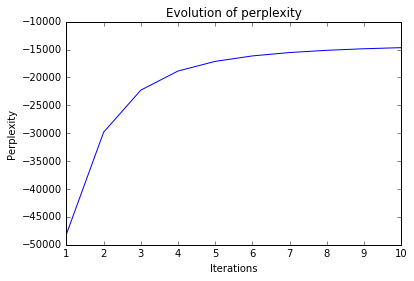

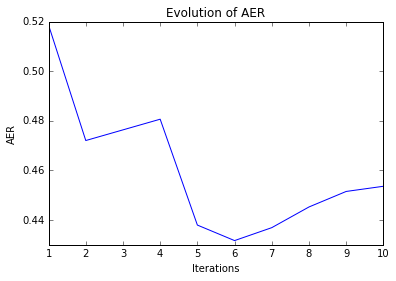

In [6]:
plt.plot(np.arange(1, len(perplexities)+1), perplexities)
plt.title("Evolution of perplexity")
plt.xlabel("Iterations")
plt.ylabel("Perplexity")
plt.show()

plt.plot(np.arange(1, len(aers)+1), aers)
plt.title("Evolution of AER")
plt.xlabel("Iterations")
plt.ylabel("AER")
plt.show()

<h1>IBM Model 2</h1>

In [8]:
def expectation_maximisation2(source_corpus, target_corpus, val_source,
                              val_target, parameters, num_iterations, 
                              min_perplexity_change, model, file_path):
    """
    Runs the EM algorithm for IBM Model 2.
    """
    
    q = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.1))))
    old_perplexity = -100000
    perplexities = []
    aers = []
    best_aer = 1
    
    with open(file_path, "a") as f:
        for k in range(0, num_iterations):
            print("Iteration #" + str(k), "out of", num_iterations - 1)

            counts_pairs = defaultdict(lambda: defaultdict(lambda: 0))
            counts_alignments = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0))))
            counts_single = defaultdict(lambda: 0)
            counts_pairs, counts_single, counts_alignments = e_step2(source_corpus, target_corpus, 
                                                                     counts_pairs, counts_single, 
                                                                     counts_alignments, q)
            parameters, q = m_step2(parameters, q, counts_alignments, counts_pairs, counts_single)
            perplexity = compute_perplexity2(parameters, q, source_corpus, target_corpus)
            alignments = get_best_alignment(val_source, val_target, parameters)
            val_aer = compute_aer(alignments, "validation/dev.wa.nonullalign")
            f.write("pp " + str(perplexity) + "\n")
            f.write("aer " + str(val_aer) + "\n")
            perplexities.append(perplexity)
            aers.append(val_aer)
            
            # Convergence in terms of training log likelihood
            if model == "likelihood":            
                if abs(perplexity - old_perplexity) < min_perplexity_change:
                    return perplexities, aers
                else:
                    old_perplexity = perplexity
            # Convergence in terms of best AER on validation data
            elif model == "aer":
                if val_aer < best_aer:
                    best_aer = val_aer
                else:
                    return perplexities, aers
        f.close()
    return perplexities, aers        


def e_step2(source_corpus, target_corpus, counts_pairs, counts_single, counts_alignments, q):
    """
    Does the E-step for IBM Model 2.
    """

    print("Doing E-step...")
    
    with progressbar.ProgressBar(max_value=len(source_corpus)) as bar:
        for n in range(len(source_corpus)):
            source_sentence = source_corpus[n]
            target_sentence = target_corpus[n]
            l = len(source_sentence)
            m = len(target_sentence)

            for i, target_word in enumerate(target_sentence):
                delta_denominator = sum([q[j_k][i][l][m]*parameters[source_sentence[j_k]][target_word] 
                                         for j_k in range(l)])

                for j, source_word in enumerate(source_sentence):
                    delta = (q[j][i][l][m]*parameters[source_word][target_word])/delta_denominator

                    counts_pairs[source_word][target_word] += delta
                    counts_single[source_word] += delta
                    counts_alignments[l][m][i][j] += delta
            bar.update(n)
    return counts_pairs, counts_single, counts_alignments


def m_step2(parameters, q, counts_alignments, counts_pairs, counts_single):
    """
    Does the M-step for IBM Model 2.
    """
    
    print("Doing M-step...")
    
    for j in q.keys():
        for i in q[j].keys():
            for l in q[j][i].keys():
                for m in q[j][i][l].keys():
                    q[j][i][l][m] = counts_alignments[l][m][i][j]/sum(counts_alignments[l][m][i].values())
    
    for source_word, target_words in parameters.items():
        for target_word in target_words:
            parameters[source_word][target_word] = \
                counts_pairs[source_word][target_word]/counts_single[source_word]
    return parameters, q


def compute_perplexity2(parameters, q, source_corpus, target_corpus):
    """
    Computes the perplexity of the corpus for IBM Model 2.
    """
    
    perplexity = 0
    
    print("Calculating perplexity...")
    
    with progressbar.ProgressBar(max_value=len(source_corpus)) as bar:
        for n in range(len(source_corpus)):
            source_sentence = source_corpus[n]
            target_sentence = target_corpus[n]
            log_sentence = 0
            l = len(source_sentence)
            m = len(target_sentence)

            for i, target_word in enumerate(target_sentence): 
                log_sum = []

                for j, source_word in enumerate(source_sentence): 
                    log_sum.append(parameters[source_word][target_word]*q[j][i][l][m])
                log_sentence += np.log(np.sum(log_sum))
            perplexity += log_sentence
            bar.update(n)
    print(perplexity)
    return perplexity
    
     
parameters = initialise_parameters(train_source, train_target, "uniform")
perplexities, aers, parameters = expectation_maximisation2(train_source, train_target, 
                                                           val_source, val_target,
                                                           parameters, 10, 1000, "aer")
alignments = get_best_alignment(test_source, test_target, parameters)
print("aer on test set")
test_aer = compute_aer(alignments, "testing/answers/test.wa.nonullalign")

Iteration #0 out of 9
-180631.830215
0.5180972078593589
Iteration #1 out of 9


ZeroDivisionError: float division by zero

# Variational Bayes IBM1

In [ ]:
def elbo(theta_dict, lambda_dict, train_source_corpus, train_target_corpus, alpha):

    elbo_first_term = compute_perplexity(theta_dict, train_source_corpus, train_target_corpus)
    elbo_second_term = 0

    for english_word in english_vocab: 
        normalization = sum([lambda_dict[english_word][french_word] for french_word in french_vocab])
        digamma_normalization = digamma(normalization)
        gammaln_normalization = gammaln(normalization)
        for french_word in french_vocab: 
            first_term = digamma(lambda_dict[english_word][french_word]) - digamma_normalization 
            first_term = first_term * (alpha - lambda_dict[english_word][french_word])
            second_term = gammaln(lambda_dict[english_word][french_word]) 
            third_term = gammaln(alpha)
            fourth_term = gammaln(len(french_vocab) * alpha)
            elbo_second_term += first_term + second_term - third_term + fourth_term - gammaln_normalization

    return elbo_first_term + elbo_second_term


alpha = 0.1
iterations = 10 

theta_dict = defaultdict(lambda: defaultdict(lambda: random.uniform(0.001, 1)))
lambda_dict = defaultdict(lambda: defaultdict(lambda: random.uniform(0.001, 1)))

english_vocab = set([word for sentence in train_source for word in sentence])
french_vocab = set([word for sentence in train_target for word in sentence])

elbos = []
aers = []

for i in range(iterations): 
    print(i, 'th iteration out of ', iterations-1)
    counts_pairs = defaultdict(lambda: defaultdict(float))
    
    # e step
    for n in range(len(train_source)):
        source_sentence = train_source[n]
        target_sentence = train_target[n]
        
        for source_word in source_sentence: 
            normalization = sum([lambda_dict[source_word][target_word] for target_word in target_sentence])
            for target_word in target_sentence: 
                value = np.exp(digamma(lambda_dict[source_word][target_word]) - digamma(normalization))
                theta_dict[source_word][target_word] += value
                counts_pairs[source_word][target_word] += value
    # m step    
    for source_word in english_vocab: 
        target_words = lambda_dict[source_word].keys()
        for target_word in target_words:
            lambda_dict[source_word][target_word] = alpha + counts_pairs[source_word][target_word]
    
    elbo_iter = elbo(theta_dict, lambda_dict, train_source, train_target, alpha)
    elbos.append(elbo_iter)
    print(elbo_iter)
    alignment = get_best_alignment(val_source, val_target, theta_dict)
    aer_iter = compute_aer(alignment)
    aers.append(aer_iter)
    print(aer_iter)

0 th iteration out of  9


In [29]:
import operator 

print(max(lambda_dict['the'].items(), key=operator.itemgetter(1))[0])
lambda_dict['the']['sénateurs']

Sénat


1.0160222191049944

In [37]:
compute_perplexity(theta_dict, train_source, train_target)

-19030.957387138806